In [30]:
import hiive.mdptoolbox.example
import hiive.mdptoolbox.mdp as mdp
import gym
import numpy as np
import matplotlib.pylab as plt
from gym.envs.toy_text.frozen_lake import generate_random_map
import seaborn as sns
plt.style.use("ggplot")

In [31]:
# Helper functions
np.random.seed(0)
def get_transitions_rewards(env, num_states, num_actions):
    reward_matrix = np.zeros((num_states, num_actions))
    transition_matrix = np.zeros((num_actions, num_states, num_states))

    for s in range(num_states):
        for a in range(num_actions):
            for proba_matrix in env.P[s][a]:
                transition_prob, new_state, reward, done = proba_matrix
                reward_matrix[s, a] = reward
                transition_matrix[a, s, new_state] += transition_prob
            transition_matrix[a, s, :] = transition_matrix[a, s,:] / np.sum(transition_matrix[a, s,:])
  
    return transition_matrix, reward_matrix
def plot_result(stats,method='PI',name='Error'):
    fun = lambda x: x[name]
    vecFun=np.vectorize(fun)
    curve = vecFun(stats)
    plt.plot(curve,label =method)
    plt.title(name)
    plt.xlabel('Iteration')
    plt.ylabel(name)

    plt.legend()

def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_bars = len(data)

    bar_width = total_width / n_bars

    bars = []

    for i, (name, values) in enumerate(data.items()):
  
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
def success(env,solver):
    print(solver.policy)
    goal=0
    total_steps=0
    success_steps=0
    for i in range(100):
        steps=0
        env.reset() 
        new_state=0
        done = False
        new_state = 0
        while not done:
            steps+=1
            new_state, reward, done, info = env.step(solver.policy[new_state])
            # env.render()
            if done:
                total_steps+=steps
                if new_state==env.observation_space.n-1:
                    success_steps+=steps     
                    goal +=1 
                
    print(f"success=%{goal}")
    if goal!=0:
        print(f"Avg success Steps= {success_steps/goal}")
    print(f"Total steps={total_steps/100}")
 
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Environment : Forrest Management

In [36]:
P, R = hiive.mdptoolbox.example.forest(S=400)#, r1=400, r2=2, p=0.1)

# Policy Iteration and Value Iteratrion

{'State': None, 'Action': None, 'Reward': 60.701641491614865, 'Error': 0.00010988313936266536, 'Time': 0.02099752426147461, 'Max V': 60.701641491614865, 'Mean V': 29.37331649432537, 'Iteration': 92}
{'State': None, 'Action': None, 'Reward': 79.49242913074468, 'Error': 7.105427357601002e-15, 'Time': 0.18810629844665527, 'Max V': 79.49242913074468, 'Mean V': 48.16335970739656, 'Iteration': 18}


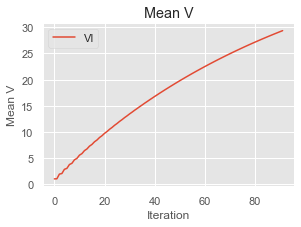

In [37]:
plt.figure(figsize=((4.5,3))) 
vi = mdp.ValueIteration(P, R, 0.99,max_iter=10000)#,epsilon=0.000001)
vi_stat = vi.run()
plot_result(vi_stat,method='VI',name='Mean V')

# PI Initialises to the policy that maximises the expected
# immediate reward
pi = mdp.PolicyIteration(P, R, 0.99,max_iter=10000)
print(vi_stat[-1])
pi_stat = pi.run()
print(pi_stat[-1])



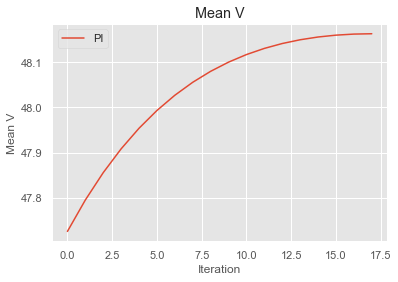

In [33]:
plot_result(pi_stat,method='PI',name='Mean V')

In [38]:
pi.policy==vi.policy

True

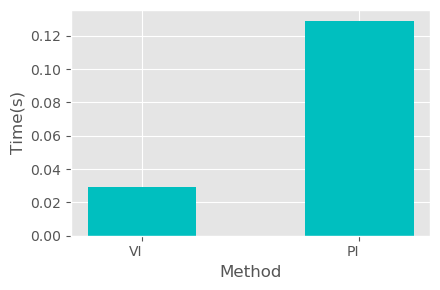

In [177]:

fig, ax = plt.subplots(figsize=(4.5,3))
ax.set_xticks(np.arange(2))
ax.bar(['VI','PI'],[vi.time,pi.time],width=0.5,align='center',color='c')
ax.set_xticklabels(['VI','PI'],rotation=0,ha='right')
plt.ylabel("Time(s)")
plt.xlabel("Method")

plt.tight_layout()

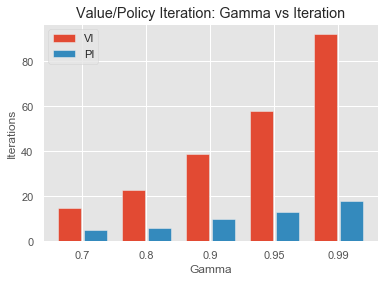

In [115]:
converge_iter = {"VI":[], "PI":[]}
converge_mean_v= {"VI":[], "PI":[]}
range_gamma = [0.7,0.8,0.9,0.95,0.99]
for gamma in range_gamma:
    vi = mdp.ValueIteration(P, R, gamma)
    vi_stat = vi.run()
    converge_iter['VI'].append(vi_stat[-1]['Iteration'])
    converge_mean_v['VI'].append(vi_stat[-1]['Mean V'])

    # converge_iter['VI'].append(np.mean(vi.V))

    pi = mdp.PolicyIteration(P, R, gamma)
    pi_stat = pi.run()
    converge_iter['PI'].append(pi_stat[-1]['Iteration'])
    converge_mean_v['PI'].append(pi_stat[-1]['Mean V'])

    # converge_iter['PI'].append(np.mean(pi.V))

    # success(env,pi)


fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(converge_iter["VI"])))
ax.set_xticks(np.arange(len(range_gamma)))
ax.set_xticklabels(range_gamma)
bar_plot(ax, converge_iter, total_width=.8, single_width=.9)

plt.xlabel('Gamma')
plt.ylabel('Iterations')
plt.title("Value/Policy Iteration: Gamma vs Iteration")
# save_fig("LLE_heart_bic_vs_k")
plt.show()


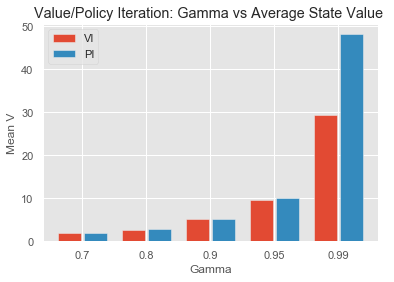

In [118]:
fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(converge_iter["VI"])))
ax.set_xticks(np.arange(len(range_gamma)))
ax.set_xticklabels(range_gamma)
bar_plot(ax, converge_mean_v, total_width=.8, single_width=.9)

plt.xlabel('Gamma')
plt.ylabel('Mean V')
plt.title("Value/Policy Iteration: Gamma vs Average State Value ")
# save_fig("LLE_heart_bic_vs_k")
plt.show()

Text(0.5, 1, 'PI/VI Policy')

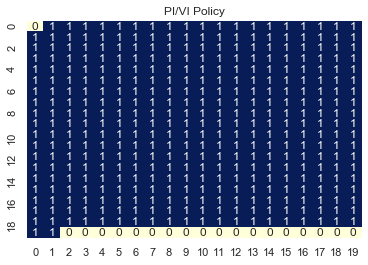

In [39]:
pol=np.array(pi.policy).reshape((20,20))
sns.set_theme()
fig, ax = plt.subplots()
ax = sns.heatmap(pol,annot=True, cmap="YlGnBu", cbar=False,fmt = '')
ax.set_title('PI/VI Policy')

In [100]:
from time import time
start = time()
ql = mdp.QLearning(P, R, 0.9, alpha=0.1,alpha_decay=0.99, epsilon=1,epsilon_min=0.1,epsilon_decay=0.99, n_iter=150000,run_stat_frequency=1)
ql_stat =ql.run()
ql_stat[-1]
time()-start

15.152151584625244

In [99]:
ql_stat[-2]['Iteration']-ql_stat[-3]['Iteration']

1

In [138]:
ql_stat[-1]

{'State': 129,
 'Action': 0,
 'Reward': 0.0,
 'Error': 3.414317489549087e-06,
 'Time': 14.451094627380371,
 'Alpha': 0.001,
 'Epsilon': 0.1,
 'Gamma': 0.9,
 'Max V': 5.035892719085206,
 'Mean V': 0.053713249828863156,
 'Iteration': 150000}

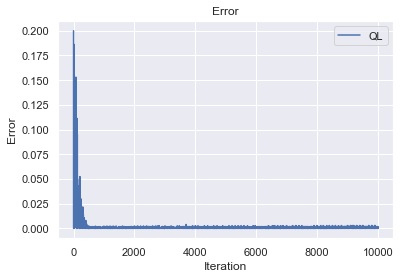

In [40]:
plot_result(ql_stat[:10000],method='QL',name='Error')

In [255]:
policy = ql.policy
reward=0
done=False
s=0
for run in range(10):
    for i in range(1,1000):
        done=False
        while not done:
            a = policy[s]
            # print('s=',s)
            # print('a=',a)

            if a==0:
                reward = reward+R[s][0]
                s= np.random.choice(np.arange(400),p=P[a][s])
                if s==0:
                    break
            else:
                done=True
                reward = reward+R[s][1]
                s=0
            # 
        
print("Average Total Return: {}".format(reward/10000))

Average Total Return: 0.8982


In [79]:
# Gamma analysis
parameters = []
Mean_V=[]
learn_time=[]
error=[]
run_stats=[]
gamma_range=[0.7,0.8,0.9,0.95,0.99]
for g in gamma_range: 
    qlearn = mdp.QLearning(P, R, g, alpha=0.2,alpha_decay=0.99, epsilon=1,epsilon_min=0.2,epsilon_decay=0.9, n_iter=10000)
    ql_final_stat =qlearn.run()
    parameters.append((alpha, min_epsilon,epsilon_decay))
    run_stats.append(ql_final_stat)
    Mean_V.append(ql_final_stat[-1]['Mean V'])
    learn_time.append(ql_final_stat[-1]['Time'])
    error.append(ql_final_stat[-1]['Error'])
    %reset_selective -f "^qlearn$"
    %reset_selective -f "^ql_final_stat$"

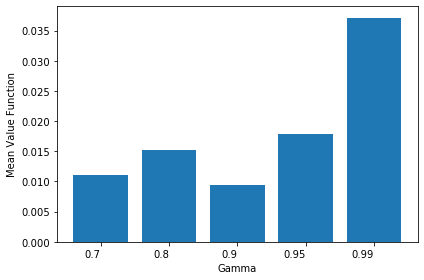

In [92]:
from matplotlib import cm

labels_g=[]
for p in gamma_range:
    labels_g.append(str(p))

fig, ax = plt.subplots()
ax.set_xticks(np.arange(len(labels_g)))
ax.bar(labels_g,Mean_V,width=0.8,align='center')
ax.set_xticklabels(labels_g,rotation=0,ha='right')
plt.ylabel("Mean Value Function")
plt.xlabel("Gamma")

plt.tight_layout()

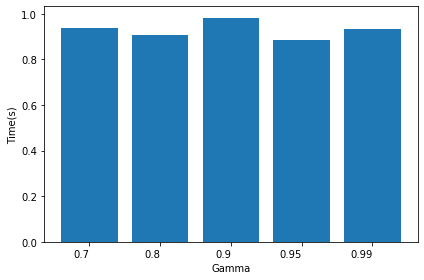

In [87]:
fig, ax = plt.subplots()
ax.set_xticks(np.arange(len(labels_g)))
ax.bar(labels_g,learn_time,width=0.8,align='center')
ax.set_xticklabels(labels_g,rotation=0,ha='right')
plt.ylabel("Time(s)")
plt.xlabel("Gamma")

plt.tight_layout()

In [47]:
from itertools import product
parameters = []
Mean_V=[]
learn_time=[]
error=[]
run_stats=[]
min_epsilon_range =[0.05,0.1,0.2]
alpha_range=[0.1,0.2]
epsilon_decay_range=[0.9,0.99,0.9999]
for alpha, min_epsilon,epsilon_decay in product(alpha_range, min_epsilon_range,epsilon_decay_range): 
    qlearn = mdp.QLearning(P, R, 0.99, alpha=alpha,alpha_decay=0.99, epsilon=1,epsilon_min=min_epsilon,epsilon_decay=epsilon_decay, n_iter=10000)
    ql_final_stat =qlearn.run()
    parameters.append((alpha, min_epsilon,epsilon_decay))
    run_stats.append(ql_final_stat)
    Mean_V.append(ql_final_stat[-1]['Mean V'])
    learn_time.append(ql_final_stat[-1]['Time'])
    error.append(ql_final_stat[-1]['Error'])
    %reset_selective -f "qlearn"
    %reset_selective -f "ql_final_stat"
    


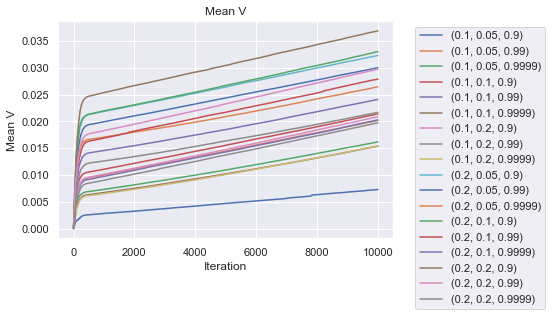

In [48]:
labels=[]
for p in parameters:
    labels.append(str(p))
for stats,tag in zip(run_stats,labels):
    # plt.figure(figsize=(8, 6))
    plot_result(stats,method=tag,name='Mean V')
    plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

{'QL(1, 2)': (1, 2), 'QL(3, 4)': (3, 4)}

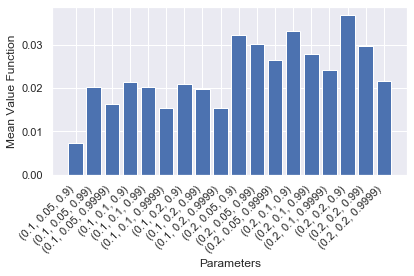

In [49]:
labels=[]
for p in parameters:
    labels.append(str(p))

fig, ax = plt.subplots()
ax.set_xticks(np.arange(len(labels)))
ax.bar(labels,Mean_V,width=0.8,align='center')
ax.set_xticklabels(labels,rotation=45,ha='right')
plt.ylabel("Mean Value Function")
plt.xlabel("Parameters")

plt.tight_layout()



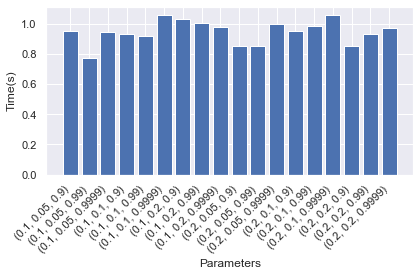

In [50]:
fig, ax = plt.subplots()
ax.set_xticks(np.arange(len(labels)))
ax.bar(labels,learn_time,width=0.8,align='center')
ax.set_xticklabels(labels,rotation=45,ha='right')
plt.ylabel("Time(s)")
plt.xlabel("Parameters")
plt.tight_layout()

In [18]:
%reset_selective -f "^ql$"
%reset_selective -f "^ql_stat$"
ql = mdp.QLearning(P, R, 0.99, alpha=0.2,alpha_decay=0.99, epsilon=1,epsilon_min=0.2,epsilon_decay=0.9, n_iter=15000)#,run_stat_frequency=1)
ql_stat =ql.run()
ql_stat[-1]

{'State': 193,
 'Action': 1,
 'Reward': 1.0,
 'Error': 0.0034160687176810894,
 'Time': 1.2976253032684326,
 'Alpha': 0.001,
 'Epsilon': 0.2,
 'Gamma': 0.99,
 'Max V': 3.088540762523351,
 'Mean V': 0.02580154547379242,
 'Iteration': 15000}

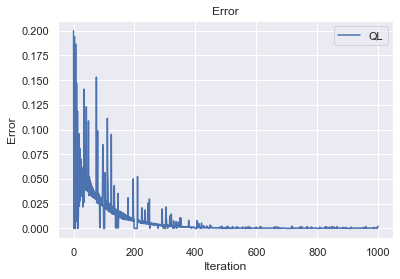

In [26]:
plot_result(ql_stat[:1000],method='QL',name='Error')

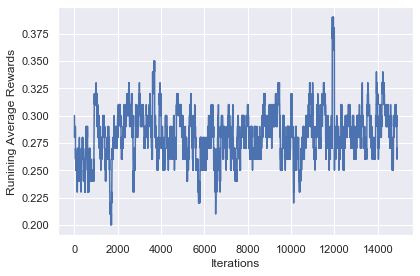

In [23]:
def running_average(x, window_size, mode='valid'):
        return np.convolve(x, np.ones(window_size)/window_size, mode=mode)

fun = lambda x: x['Reward']
vecFun=np.vectorize(fun)
curve = vecFun(ql_stat)
rew= running_average(curve, 100, mode='valid')
plt.plot(rew)

plt.ylabel("Runining Average Rewards")
plt.xlabel("Iterations")

plt.tight_layout()


Text(0.5, 1, 'QL Policy')

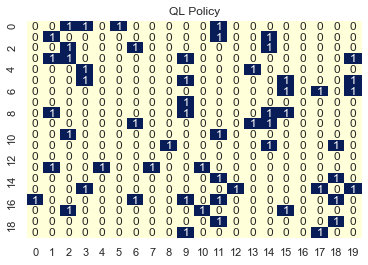

In [24]:
pol=np.array(ql.policy).reshape((20,20))
sns.set_theme()

fig, ax = plt.subplots()
ax = sns.heatmap(pol,annot=True, cmap="YlGnBu", cbar=False,fmt = '')
ax.set_title('QL Policy')

In [54]:
%reset_selective -f "^ql$"
%reset_selective -f "^ql_stat$"
ql = mdp.QLearning(P, R, 0.99, alpha=0.2,alpha_decay=0.99, epsilon=1,epsilon_min=0.2,epsilon_decay=0.9, n_iter=2000000)#,run_stat_frequency=1)
ql_stat =ql.run()
ql_stat[-1]

{'State': 249,
 'Action': 1,
 'Reward': 1.0,
 'Error': 0.04429379981835297,
 'Time': 138.1096408367157,
 'Alpha': 0.001,
 'Epsilon': 0.2,
 'Gamma': 0.99,
 'Max V': 47.648038896172324,
 'Mean V': 2.714623810461565,
 'Iteration': 2000000}

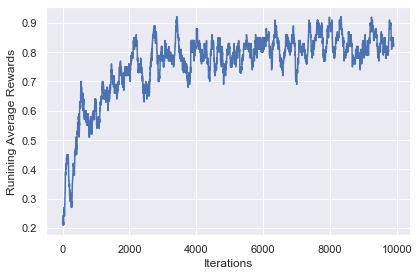

In [55]:
def running_average(x, window_size, mode='valid'):
        return np.convolve(x, np.ones(window_size)/window_size, mode=mode)

fun = lambda x: x['Reward']
vecFun=np.vectorize(fun)
curve = vecFun(ql_stat)
rew= running_average(curve, 100, mode='valid')
plt.plot(rew)

plt.ylabel("Runining Average Rewards")
plt.xlabel("Iterations")

plt.tight_layout()

Text(0.5, 1, 'QL Policy')

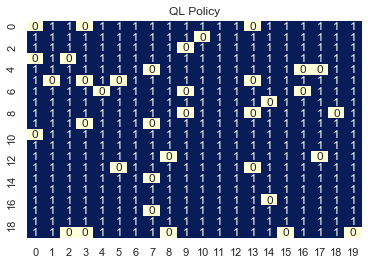

In [56]:
pol=np.array(ql.policy).reshape((20,20))
sns.set_theme()

fig, ax = plt.subplots()
ax = sns.heatmap(pol,annot=True, cmap="YlGnBu", cbar=False,fmt = '')
ax.set_title('QL Policy')